# Semi-Supervised Emotion Recognition
VCS Project 2021

By: Derek Sweet, Johanna Weiss, and Lisa German

Motivated by a real world business problem, we are looking to see if we can detect when people get scared going through a haunted house. This will be useful in identifying issues with the attraction where people are not getting scared. If used in the real world, the data would come from security cameras placed throughout the attraction. There are four main tasks needed in order to build a proof of concept:
1.   Train a model to be able to detect emotions
2.   Build a pipeline that allows the model to be fine tuned on unlabeled data specific to the task (footage in the haunted house)
3.   Restore faces that are difficult to see
4.   Detect emotions in real time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# #####################
# # INSTALL AND IMPORT #
# #####################

# Installs
!pip install keras_vggface
!pip install keras_applications
!pip install keras_preprocessing
!pip install bm3d
# !pip install bing-images

# # Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import sys
import math
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import imgaug.augmenters as iaa
import bm3d
from sklearn.metrics import average_precision_score
# from bing_images import bing
# import requests

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D, Input, Conv2DTranspose, MaxPool2D, UpSampling2D, Reshape, LeakyReLU, Lambda
from keras.optimizers import RMSprop,SGD,Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import utils as np_utils
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras_vggface.vggface import VGGFace

     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 8.4MB 6.8MB/s 


In [ ]:
##################
# UTIL FUNCTIONS #
##################

# Function to resize images
def resize(image):
  """
  Parameters:
  image: numpay array of image

  Return:
  new_image: numpy array of reshaped image 
  """
  # Get the height and width of original image
  (orig_h, orig_w) = image.shape[:2]

  # Skip small images
  if min(orig_h,orig_w) >= 48:

    # Resize image
    new_image = cv2.resize(image, (48,48), interpolation = cv2.INTER_AREA)

  return new_image


# Function to plot model loss
def plot_loss(history):
  """
  Parameters:
  history: Keras fit history object

  Return:
  Plot of loss learning curve
  """
  plt.figure(figsize=(10,8))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')


# Function to plot the original, noise, and reconstructed faces
def plot_img(n, target_data,input_data, decoded_imgs):
  """
  Parameters:
  n: number of images to display
  target_data: original images in numpy array
  input_data: noise images in numpy array
  decoded_imgs: noise decoded images in numpy array

  Return:
  Displays three rows of face images original, noise, and reconstructed
  """
  plt.figure(figsize=(30, 6))
  for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(target_data[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noise
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(input_data[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(decoded_imgs[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def compare_psnr(img1, img2):
  mse = np.mean( (img1 - img2) ** 2 )
  if mse == 0:
    return 100, mse
  PIXEL_MAX = 255.0
  return 20 * math.log10(PIXEL_MAX / math.sqrt(mse)), mse

def plot_confusion_matrix(matrix, title):

    labels = ["ANGRY", "DISGUST", "FEAR", "HAPPY", "SAD", "SURPRISE", "CONTEMPT"]
    sns.set(font_scale=1.5)
    plt.figure(figsize=(12,5))
    sns.heatmap(matrix, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize = 25)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 10)
    plt.xticks(rotation = 90)
    plt.show()
    print("-"* 85)

def predict_and_measure(model, X_test, y_test):
  """
  Parameters
  model: keras model
  X_test: image inputs
  y_test: image classifications

  Returns
  y_pred: softmax prediction
  y_pred_bool: argmax of y_pred
  ap_list: the average percision by class
  ap: the average of ap_list
  plot of confusion matrix
  """

  # Predict
  y_pred = model.predict(X_test, batch_size=32, verbose=1)
  y_pred_bool = np.argmax(y_pred, axis=1)
  y_test_bool = np.argmax(y_test, axis=1)

  # Confusion matrix
  df_confusion = confusion_matrix(y_pred_bool, y_test_bool)
  precision = df_confusion/df_confusion.sum(axis = 0)
  recall = (df_confusion.T/df_confusion.sum(axis = 1)).T
  plot_confusion_matrix(recall, 'Recall')
  plot_confusion_matrix(precision, 'Precision')

  # Calculate mAP
  ap_list = average_precision_score(y_test, y_pred, average = None)
  ap = np.mean(ap_list)

  return y_pred, y_pred_bool, ap_list, ap


def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

def toThreeChannels(dataset):
  output=list()
  for i in range(dataset.shape[0]):
    output.append(np.concatenate((dataset[i],)*3,axis=-1))
  return np.array(output)

In [ ]:
####################
# GLOBAL VARIABLES #
####################

base_path = '/content/drive/MyDrive/UNIPD/Semester2/Vision and Cognitive Services/VIS_Project_EmoDetection/'
num_classes = 7
label_names = ['Angry', 'Disgust', 'Fear', 'Happy','Sad','Surprise','Neutral']
img_rows,img_cols=48,48
batch_size = 32

## Load Base Data

The models used for face emotion detection will be built on:

* FER-2013 dataset (https://www.kaggle.com/deadskull7/fer2013)
* CK+ dataset (https://www.kaggle.com/shawon10/ckplus) 
* Bing custom query scrape

Together they contain over 36k labeled images mapped to the following emotions:

0. Angry
1. Disgust
2. Fear
3. Happy
4. Sad
5. Surprise
6. Neutral




#### FER-2013 Data

Quick description of the data

In [ ]:
# ##########################################################################
# # LOAD FER-2013 DATA - UNCOMMENT IF CHANGES ARE MADE TO THE ORIGINAL CSV #
# ##########################################################################

# # Load FER-2013 Data

# fer = pd.read_csv('/content/drive/MyDrive/UNIPD/Semester2/Vision and Cognitive Services/VIS_Project_EmoDetection/data/fer2013.csv')

# fer_X = np.array([np.fromstring(img, dtype=int, sep=' ').reshape(48,48,1) for img in fer['pixels']])
# fer_y = np.array(fer['emotion'])

#### CK+48 Data
Quick descriotion of the data

In [ ]:
# ##########################################################################
# # LOAD CK+48 DATA - UNCOMMENT IF CHANGES ARE MADE TO THE ORIGINAL IMAGES #
# ##########################################################################

# ck_path = '/content/drive/MyDrive/UNIPD/Semester2/Vision and Cognitive Services/VIS_Project_EmoDetection/data/CK+48'
# labels = sorted(os.listdir(ck_path))
# labels.remove('contempt')
# labels.append('contempt')

# ck_X = []
# ck_y = []

# n = 0
# for idx, label in enumerate(labels):
#   images_path = os.path.join(ck_path, label)
#   files = os.listdir(images_path)

#   print(f"Loading training images ({label})...")

#   for image in files:
#       img_path = os.path.join(images_path, image)
#       img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#       ck_X.append(img)
#       ck_y.append(idx)
#       n += 1

# ck_X = np.array(ck_X).reshape(981, 48, 48, 1)
# ck_y = np.array(ck_y)  
# print(f"CK image load is complete!")

Loading training images (anger)...
Loading training images (disgust)...
Loading training images (fear)...
Loading training images (happy)...
Loading training images (sadness)...
Loading training images (surprise)...
Loading training images (contempt)...
CK image load is complete!


#### Combine FER & CK

In [ ]:
# # #########################################################################
# # # COMBINE FER AND CK DATA - UNCOMMENT IF CHANGES WERE MADE TO FAE OR CK #
# # #########################################################################

# X = np.concatenate((fer_X, ck_X), axis=0)
# print(X.shape)
# y = np.concatenate((fer_y, ck_y), axis=0)
# print(y.shape)

# #Save data to Google Drive to prevent having to load data again
# np.save(os.path.join(base_path, 'data/data_X.npy'), X)
# np.save(os.path.join(base_path, 'data/data_y.npy'), y)

(36868, 48, 48, 1)
(36868,)


In [ ]:
#######################################
# LOAD FER AND CK DATA FROM .NPY FILE #
#######################################

X = np.load(os.path.join(base_path, 'data/data_X.npy'))/255
y = np.load(os.path.join(base_path, 'data/data_y.npy'))

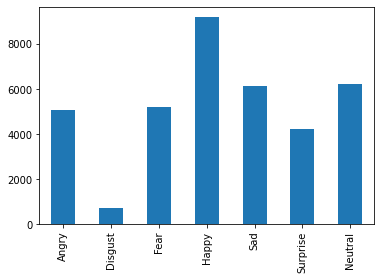

In [ ]:
###################################################
# TEST/TRAIN/VAL SPLIT AND VISUALIZE DISTRIBUTION #
###################################################

# Split into test and train
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
y_train_original = y_train.copy()
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

# Create three channel grayscale for VGG
X_train_VGG= toThreeChannels(X_train)
X_val_VGG= toThreeChannels(X_val)
X_test_VGG= toThreeChannels(X_test)

# Plot distribution
y_distribution = pd.Series(y).value_counts().sort_index(ascending=True)
y_distribution.index = label_names
ax = y_distribution.plot.bar()

#### Image Augmentations

Put description here

In [ ]:
#############################
# APPLY IMAGE AUGMENTATIONS # 
#############################

# datagen = ImageDataGenerator(
#     #rotation_range=30,
#     shear_range=0.15,
#     zoom_range=0.2)
    
#     #width_shift_range=0.1,
#     #height_shift_range=0.1,
#     #horizontal_flip=True,
#     #fill_mode='nearest'
#     #validation_split=0.2

datagen = ImageDataGenerator(
                    # rescale=1./255,
                    featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=10,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True)


## CNN Models

A simple CNN will be used as the control model to test the increased performance of all the following experiments. The network has \**put architecture description here\**

#### Initialization for Modeling

In [ ]:
########################
# INITIALIZE CALLBACKS #
########################

earlystop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.3,
                              patience=2,
                              verbose=1,
                              mode='max',
                              min_lr=5e-8)

callbacks = [earlystop,reduce_lr]


#### BASIC CNN MODEL
Description goes here

In [ ]:
###########################################################
# LOAD MODEL - IN ORDER TO SKIP THE TRAINING OF THE MODEL #
###########################################################

# Load json and create model
json_file = open(os.path.join(base_path, 'BaseModel.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
base_model = model_from_json(loaded_model_json)

# Load weights into new model
base_model.load_weights(os.path.join(base_path, 'BaseModel.h5'))

print("Loaded model from Google Drive")

# Complie M0del
base_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Summarize Model
print(base_model.summary())

Loaded model from Google Drive
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)        

In [ ]:
# ##################################
# # BUILD BASIC MODEL ARCHITECTURE #
# ##################################

# base_model = Sequential()

# # TODO: BE ABLE TO EXPLAIN HE_NORMAL

# base_model.add(Conv2D(16,(3,3),padding='same', kernel_initializer='he_normal', activation="relu", input_shape=(img_rows,img_cols,1)))
# base_model.add(MaxPooling2D(pool_size=(3,3)))
# base_model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation="relu"))
# base_model.add(MaxPooling2D(pool_size=(2,2)))
# base_model.add(Flatten())
# base_model.add(Dense(512, kernel_initializer='he_normal',  activation="relu"))
# base_model.add(Dropout(0.2))
# base_model.add(Dense(256, kernel_initializer='he_normal', activation="relu"))
# base_model.add(BatchNormalization())
# base_model.add(Dense(128,kernel_initializer='he_normal',  activation="relu"))              
# base_model.add(Dense(64, kernel_initializer='he_normal', activation="relu"))
# base_model.add(Dense(num_classes,kernel_initializer='he_normal',  activation="softmax"))

# print(base_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [ ]:
##############################
# COMPILE AND FIT BASE MODEL #
##############################

# nb_train_samples = X_train.shape[0]
# nb_validation_samples = X_val.shape[0]

# base_model.compile(loss='categorical_crossentropy',
#               optimizer = Adam(learning_rate=0.001),
#               metrics=['accuracy'])

# base_history=base_model.fit(
#                 datagen.flow(X_train, y_train, batch_size=batch_size),
#                 steps_per_epoch=nb_train_samples//batch_size,
#                 epochs=30,
#                 callbacks=callbacks,
#                 validation_data=datagen.flow(X_val, y_val),
#                 validation_steps=nb_validation_samples//batch_size)

In [ ]:
# ##############################################################
# # SAVE MODEL - ONLY USE IF YOU LIKE THE MODEL AFTER TRAINING #
# ##############################################################

# # Serialize model to JSON
# model_json = base_model.to_json()
# with open(os.path.join(base_path, 'BaseModel.json'), "w") as json_file:
#     json_file.write(model_json)

# # Serialize weights to HDF5
# base_model.save_weights(os.path.join(base_path, 'BaseModel.h5'))

# print("Saved model to Google Drive")

Saved model to Google Drive


116/116 - 2s - loss: 1.1532 - accuracy: 0.5742
accuracy: 57.42%


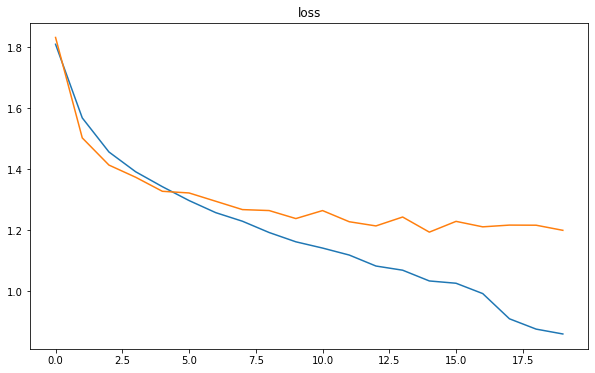

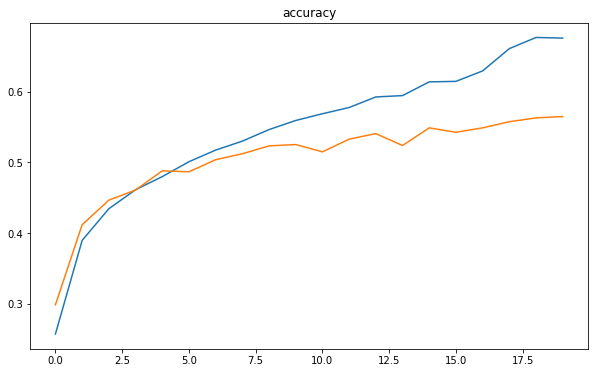

In [ ]:
# #################################
#  # PLOT RESULTS FROM BASE MODEL #
# #################################
# DON'T RUN THIS IF NOT RE-TRAINING THE MODEL

plot_loss(base_history)

plot_accuracy(base_history)  

scores = base_model.evaluate(X_test, y_test, verbose=2)

116/116 [==============================] - 0s 2ms/step


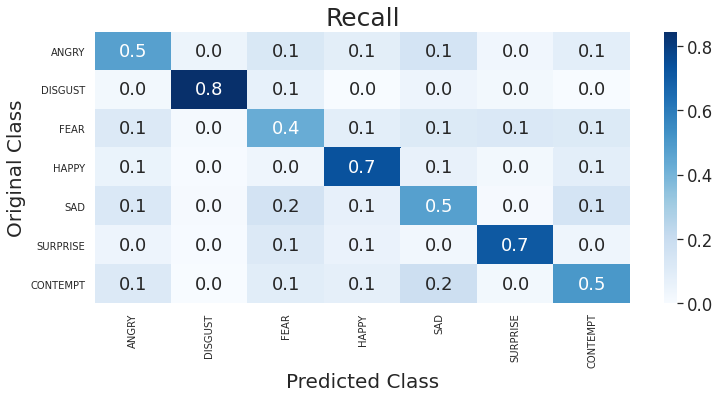

-------------------------------------------------------------------------------------


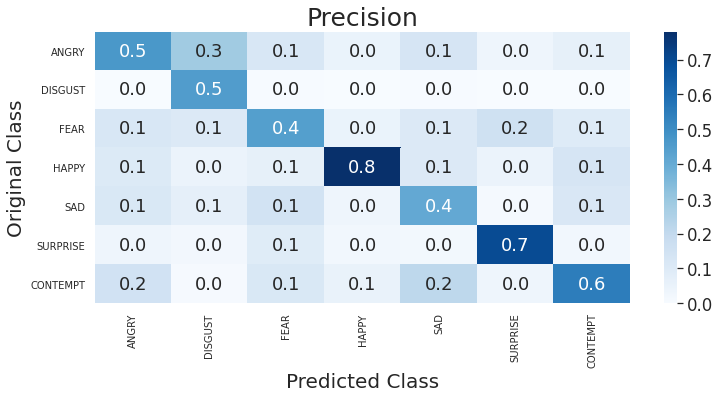

-------------------------------------------------------------------------------------
[0.49805245 0.64696428 0.44109303 0.86628712 0.46837602 0.78141145
 0.56860179] 0.6101123055161471


In [ ]:
#####################################
# MEASURE PERFORMANCE OF BASE MODEL #
#####################################

base_y_pred, base_y_pred_bool, base_ap_list, base_ap = predict_and_measure(base_model, X_test, y_test)
print(base_ap_list, base_ap)

#### VGG16 (imagenet) frozen layers

In [ ]:
###########################################################
# LOAD MODEL - IN ORDER TO SKIP THE TRAINING OF THE MODEL #
###########################################################

# Load json and create model
json_file = open(os.path.join(base_path, 'VGG_frozen.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
vgg_frozen_model = model_from_json(loaded_model_json)

# Load weights into new model
vgg_frozen_model.load_weights(os.path.join(base_path, 'VGG_frozen.h5'))

print("Loaded model from Google Drive")

# Complie Model
vgg_frozen_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Summarize Model
print(vgg_frozen_model.summary())

Loaded model from Google Drive
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)  

In [ ]:
# #################################
# # INITIALIZE VGG16 FROZEN MODEL #
# #################################

# # IMport pre-trained model
# vgg_frozen_model=VGG16(
#     include_top=False,
#     weights="imagenet", input_shape=(48,48,3))
  
# # Freeze all but dense layers
# for layers in (vgg_frozen_model.layers)[:19]:
#     print(layers)
#     layers.trainable = False

# # Add new dense layers to the model architecture
# X = vgg_frozen_model.layers[-1].output
# X1 = Flatten()(X)
# X2 = Dense(512, activation='relu')(X1)
# X3 = Dropout(0.5)(X2)
# X4 = Dense(256, activation='relu')(X3)
# X5 = BatchNormalization()(X4)
# X6 = Dense(128, activation='relu')(X5)
# X7 = Dense(64, activation='relu')(X6)
# predictions = Dense(num_classes, activation="softmax")(X7)

# vgg_frozen_model = Model(inputs = vgg_frozen_model.input, outputs = predictions)

# # Compile and summarize model
# vgg_frozen_model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.001), metrics=["accuracy"])
# vgg_frozen_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [ ]:
##########################
# FIT VGG16 FROZEN MODEL #
##########################

nb_train_samples = X_train.shape[0]
nb_validation_samples = X_val.shape[0]

earlystop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.3,
                              patience=2,
                              verbose=1,
                              mode='max',
                              min_lr=5e-8)

callbacks = [earlystop,reduce_lr]

vgg_frozen_history=vgg_frozen_model.fit(
                datagen.flow(X_train_VGG, y_train, batch_size=batch_size),
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=50,
                callbacks=callbacks,
                validation_data=datagen.flow(X_val_VGG, y_val),
                validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
921/921 [==============================] - 25s 25ms/step - loss: 1.8138 - accuracy: 0.2561 - val_loss: 1.6734 - val_accuracy: 0.3313
Epoch 2/50
921/921 [==============================] - 22s 24ms/step - loss: 1.6988 - accuracy: 0.3258 - val_loss: 1.6329 - val_accuracy: 0.3535
Epoch 3/50
921/921 [==============================] - 22s 24ms/step - loss: 1.6558 - accuracy: 0.3472 - val_loss: 1.6180 - val_accuracy: 0.3649
Epoch 4/50
921/921 [==============================] - 22s 24ms/step - loss: 1.6366 - accuracy: 0.3528 - val_loss: 1.6038 - val_accuracy: 0.3712
Epoch 5/50
921/921 [==============================] - 22s 24ms/step - loss: 1.6317 - accuracy: 0.3609 - val_loss: 1.6131 - val_accuracy: 0.3571
Epoch 6/50
921/921 [==============================] - 22s 24ms/step - loss: 1.6157 - accuracy: 0.3676 - val_loss: 1.5769 - val_accuracy: 0.3788
Epoch 7/50
921/921 [==============================] - 22s 24ms/step - loss: 1.6116 - accuracy: 0.3680 - val_loss: 1.5829 - val_accuracy:

In [ ]:
# ##############################################################
# # SAVE MODEL - ONLY USE IF YOU LIKE THE MODEL AFTER TRAINING #
# ##############################################################

# # Serialize model to JSON
# model_json = vgg_frozen_model.to_json()
# with open(os.path.join(base_path, 'VGG_frozen.json'), "w") as json_file:
#     json_file.write(model_json)

# # Serialize weights to HDF5
# vgg_frozen_model.save_weights(os.path.join(base_path, 'VGG_frozen.h5'))

# print("Saved model to Google Drive")

Saved model to Google Drive


116/116 - 2s - loss: 1.4796 - accuracy: 0.4296


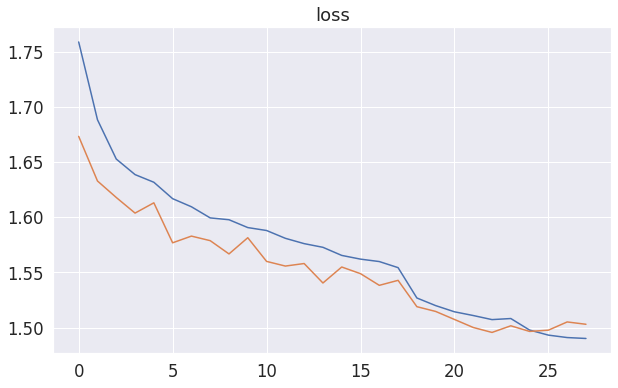

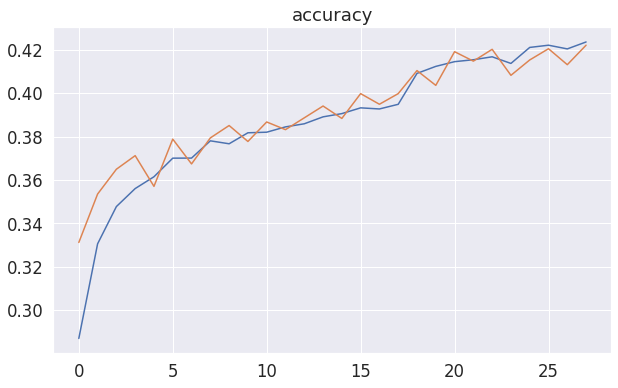

In [ ]:
# ###############################################
# # DON'T RUN THIS IF NOT RE-TRAINING THE MODEL #
# ###############################################
plot_loss(vgg_frozen_history)

plot_accuracy(vgg_frozen_history)  

scores = vgg_frozen_model.evaluate(X_test_VGG, y_test, verbose=2)

116/116 [==============================] - 1s 7ms/step


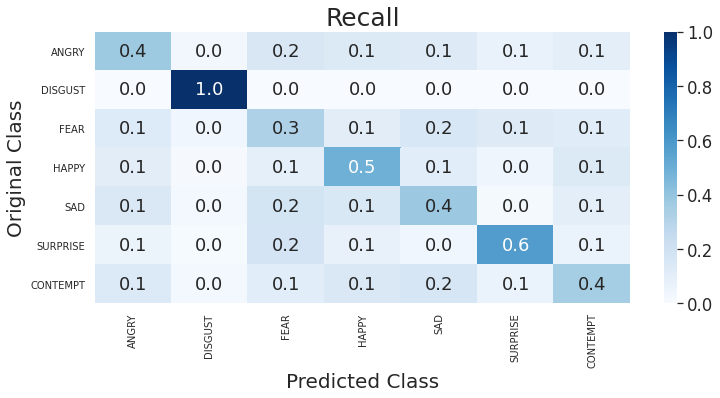

-------------------------------------------------------------------------------------


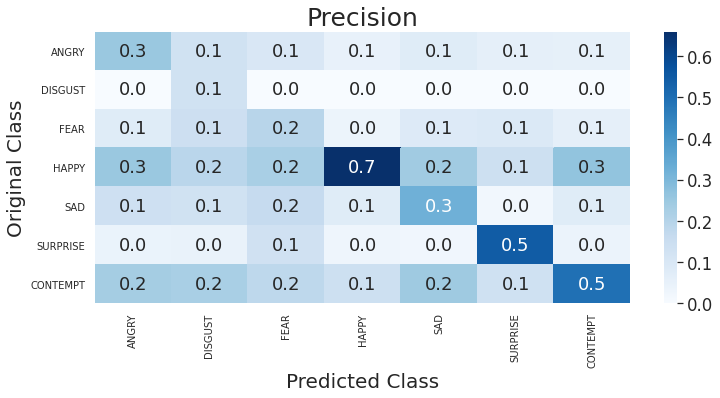

-------------------------------------------------------------------------------------
[0.341809   0.30168796 0.288767   0.59289108 0.3551185  0.60599514
 0.39356152] 0.4114043141242975


In [ ]:
###########################################
# MEASURE PERFORMANCE OF VGG FROZEN MODEL #
###########################################

vgg_frozen_y_pred, vgg_frozen_y_pred_bool, vgg_frozen_ap_list, vgg_frozen_ap = predict_and_measure(vgg_frozen_model,X_test_VGG,y_test)
print(vgg_frozen_ap_list, vgg_frozen_ap)

###VGG (imagenet) all trainable

In [ ]:
###########################################################
# LOAD MODEL - IN ORDER TO SKIP THE TRAINING OF THE MODEL #
###########################################################

# Load json and create model
json_file = open(os.path.join(base_path, 'VGG_full_train.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
vgg_full_model = model_from_json(loaded_model_json)

# Load weights into new model
vgg_full_model.load_weights(os.path.join(base_path, 'VGG_full_train.h5'))

print("Loaded model from Google Drive")

# Complie M0del
vgg_full_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Summarize Model
print(vgg_full_model.summary())

Loaded model from Google Drive
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)  

In [ ]:
# ########################################
# # INITIALIZE VGG16 ALL TRAINABLE MODEL #
# ########################################

# # Import pre-trained model
# vgg_full_model=VGG16(
#     include_top=False,
#     weights="imagenet", input_shape=(48,48,3))

# # Unlock all layers
# for i, layer in enumerate(vgg_full_model.layers):
#     print(i, layer.name, layer.trainable)

# # Add fully connected layers
# X = vgg_full_model.layers[-1].output
# X1 = Flatten()(X)
# X2 = Dense(512, activation='relu')(X1)
# X3 = Dropout(0.6)(X2)
# X4 = Dense(256, activation='relu')(X3)
# X5 = BatchNormalization()(X4)
# X6 = Dense(128, activation='relu')(X5)
# X7 = Dense(64, activation='relu')(X6)
# predictions = Dense(num_classes, activation="softmax")(X7)

# vgg_full_model = Model(inputs = vgg_full_model.input, outputs = predictions)

# # Compile and sumarize
# vgg_full_model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.00001), metrics=["accuracy"])
# vgg_full_model.summary()



0 input_4 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
__________

In [ ]:
# # #################################
# # # FIT VGG16 ALL TRAINABLE MODEL #
# # #################################

# nb_train_samples = X_train.shape[0]
# nb_validation_samples = X_val.shape[0]

# earlystop = EarlyStopping(monitor='val_loss',
#                           patience=5,
#                           verbose=1,
#                           restore_best_weights=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
#                               factor=0.3,
#                               patience=2,
#                               verbose=1,
#                               mode='max',
#                               min_lr=5e-8)

# callbacks = [earlystop,reduce_lr]

# vgg_full_history=vgg_full_model.fit(
#                 datagen.flow(X_train_VGG, y_train, batch_size=batch_size),
#                 steps_per_epoch=nb_train_samples//batch_size,
#                 epochs=50,
#                 callbacks=callbacks,
#                 validation_data=datagen.flow(X_val_VGG, y_val),
#                 validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
921/921 [==============================] - 28s 28ms/step - loss: 2.0757 - accuracy: 0.1766 - val_loss: 1.7752 - val_accuracy: 0.3307

Epoch 00001: val_loss did not improve from 1.01307
Epoch 2/50
921/921 [==============================] - 25s 27ms/step - loss: 1.6789 - accuracy: 0.3424 - val_loss: 1.4739 - val_accuracy: 0.4505

Epoch 00002: val_loss did not improve from 1.01307
Epoch 3/50
921/921 [==============================] - 25s 27ms/step - loss: 1.4992 - accuracy: 0.4310 - val_loss: 1.4128 - val_accuracy: 0.4682

Epoch 00003: val_loss did not improve from 1.01307
Epoch 4/50
921/921 [==============================] - 25s 27ms/step - loss: 1.4080 - accuracy: 0.4656 - val_loss: 1.3184 - val_accuracy: 0.4978

Epoch 00004: val_loss did not improve from 1.01307
Epoch 5/50
921/921 [==============================] - 25s 27ms/step - loss: 1.3432 - accuracy: 0.4935 - val_loss: 1.3280 - val_accuracy: 0.5003

Epoch 00005: val_loss did not improve from 1.01307
Epoch 6/50
921/921 [

116/116 - 2s - loss: 0.9521 - accuracy: 0.6678


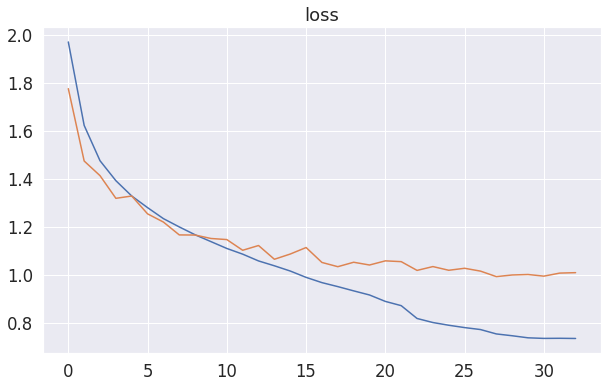

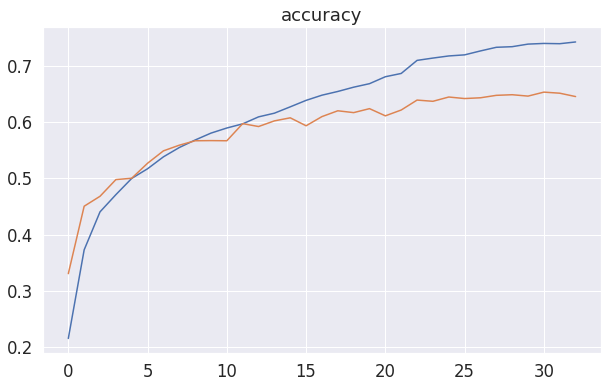

In [ ]:
# ###############################################
# # DON'T RUN THIS IF NOT RE-TRAINING THE MODEL #
# ###############################################
plot_loss(vgg_full_history)

plot_accuracy(vgg_full_history)  

scores = vgg_full_model.evaluate(X_test_VGG, y_test, verbose=2)

116/116 [==============================] - 2s 8ms/step


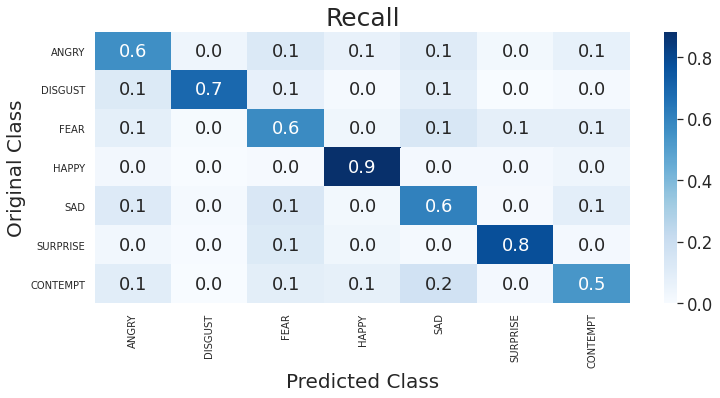

-------------------------------------------------------------------------------------


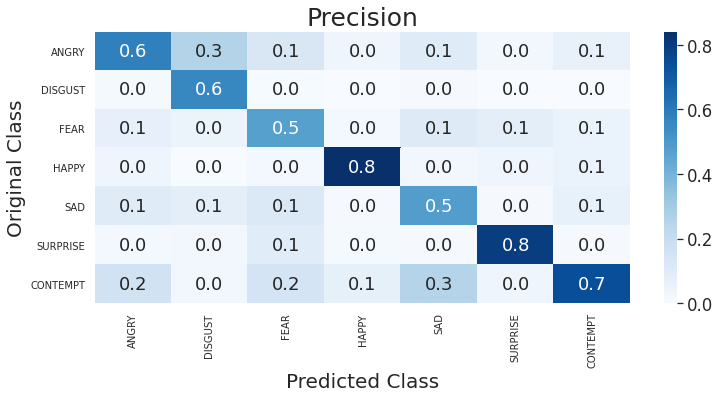

-------------------------------------------------------------------------------------
[0.63104753 0.66054921 0.5656798  0.93455203 0.59821391 0.8554027
 0.64985627] 0.6993287787717108


In [ ]:
#########################################
# MEASURE PERFORMANCE OF VGG FULL MODEL #
#########################################

vgg_full_y_pred, vgg_full_y_pred_bool, vgg_full_ap_list, vgg_full_ap = predict_and_measure(vgg_full_model,X_test_VGG,y_test)
print(vgg_full_ap_list, vgg_full_ap)

In [ ]:
# ##############################################################
# # SAVE MODEL - ONLY USE IF YOU LIKE THE MODEL AFTER TRAINING #
# ##############################################################

# # Serialize model to JSON
# model_json = vgg_full_model.to_json()
# with open(os.path.join(base_path, 'VGG_full_train.json'), "w") as json_file:
#     json_file.write(model_json)

# # Serialize weights to HDF5
# vgg_full_model.save_weights(os.path.join(base_path, 'VGG_full_train.h5'))

# print("Saved model to Google Drive")

Saved model to Google Drive


### ResNet50

In [ ]:
##################################
# INITIALIZE RESNET FROZEN MODEL #
##################################

input_t = tf.keras.Input(shape=(48,48,3))

res_model=ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=input_t,
    input_shape=(48,48,3))

for i, layer in enumerate(res_model.layers):
  layer.trainable = True
  print(i, layer.name, layer.trainable)

resnet_model = Sequential()
resnet_model.add(res_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation="relu"))
resnet_model.add(Dropout(0.6))
resnet_model.add(Dense(256,activation="relu"))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(128,activation="relu"))
resnet_model.add(Dense(64, activation="relu"))
resnet_model.add(Dense(num_classes, activation='softmax'))

# resnet_model.built = True
# resnet_model.load_weights(os.path.join(base_path, 'ResNet.h5'))

resnet_model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.00001), metrics=["accuracy"])

0 input_21 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tr

ValueError: ignored

In [ ]:
# ##################################
# # FIT RESNET ALL TRAINABLE MODEL #
# ##################################


# nb_train_samples = X_train.shape[0]
# nb_validation_samples = X_val.shape[0]

# earlystop = EarlyStopping(monitor='val_loss',
#                           patience=5,
#                           verbose=1,
#                           restore_best_weights=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
#                               factor=0.3,
#                               patience=2,
#                               verbose=1,
#                               mode='max',
#                               min_lr=5e-8)

# callbacks = [earlystop,reduce_lr]

# resnet_history=resnet_model.fit(
#                 datagen.flow(X_train_VGG, y_train, batch_size=batch_size),
#                 steps_per_epoch=nb_train_samples//batch_size,
#                 epochs=50,
#                 callbacks=callbacks,
#                 validation_data=datagen.flow(X_val_VGG, y_val),
#                 validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
921/921 [==============================] - 67s 47ms/step - loss: 1.9852 - accuracy: 0.1735 - val_loss: 2.7138 - val_accuracy: 0.1910
Epoch 2/50
921/921 [==============================] - 42s 45ms/step - loss: 1.8737 - accuracy: 0.2253 - val_loss: 1.7982 - val_accuracy: 0.2924
Epoch 3/50
921/921 [==============================] - 42s 45ms/step - loss: 1.7943 - accuracy: 0.2718 - val_loss: 1.6822 - val_accuracy: 0.3326
Epoch 4/50
921/921 [==============================] - 42s 45ms/step - loss: 1.7220 - accuracy: 0.3190 - val_loss: 1.6318 - val_accuracy: 0.3495
Epoch 5/50
921/921 [==============================] - 42s 45ms/step - loss: 1.6623 - accuracy: 0.3477 - val_loss: 1.6043 - val_accuracy: 0.3791
Epoch 6/50
921/921 [==============================] - 42s 45ms/step - loss: 1.6182 - accuracy: 0.3645 - val_loss: 1.5486 - val_accuracy: 0.4111
Epoch 7/50
921/921 [==============================] - 42s 45ms/step - loss: 1.5769 - accuracy: 0.3857 - val_loss: 1.5321 - val_accuracy:

In [ ]:
# ##############################################################
# # SAVE MODEL - ONLY USE IF YOU LIKE THE MODEL AFTER TRAINING #
# ##############################################################

# # Serialize model to JSON
# model_json = resnet_model.to_json()
# with open(os.path.join(base_path, 'ResNet.json'), "w") as json_file:
#     json_file.write(model_json)

# # Serialize weights to HDF5
# resnet_model.save_weights(os.path.join(base_path, 'ResNet.h5'))

# print("Saved model to Google Drive")

Saved model to Google Drive


116/116 - 3s - loss: 1.0275 - accuracy: 0.6357


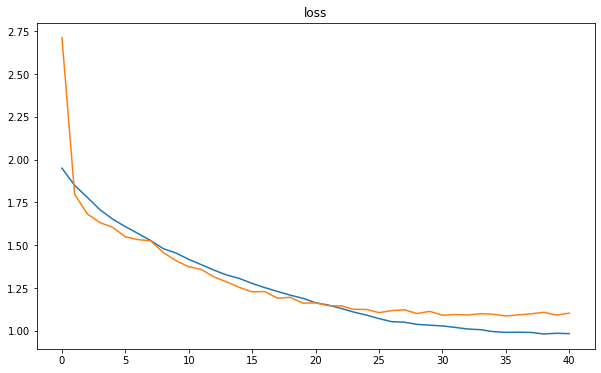

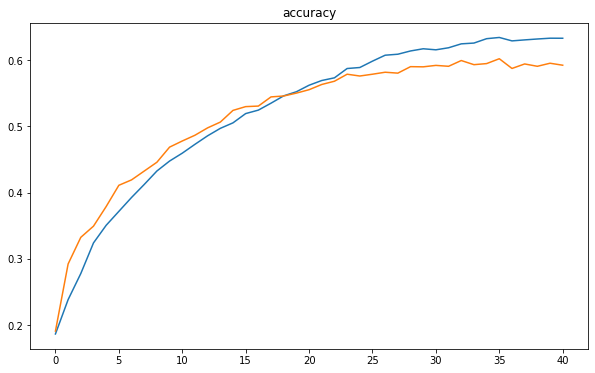

In [ ]:
# ###############################################
# # DON'T RUN THIS IF NOT RE-TRAINING THE MODEL #
# ###############################################
plot_loss(resnet_history)

plot_accuracy(resnet_history)  

scores = resnet_model.evaluate(X_test_VGG, y_test, verbose=2)

116/116 [==============================] - 2s 12ms/step


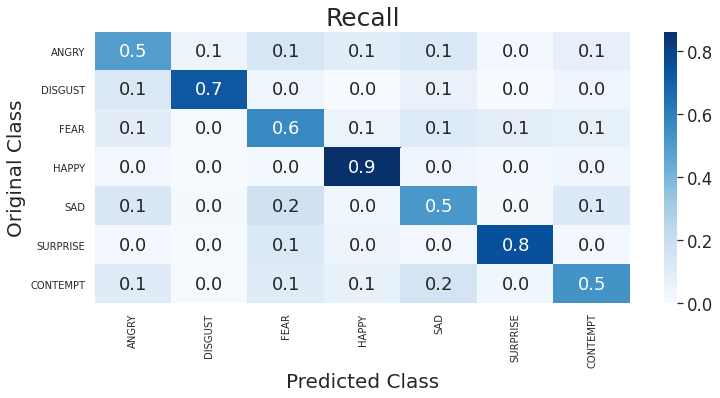

-------------------------------------------------------------------------------------


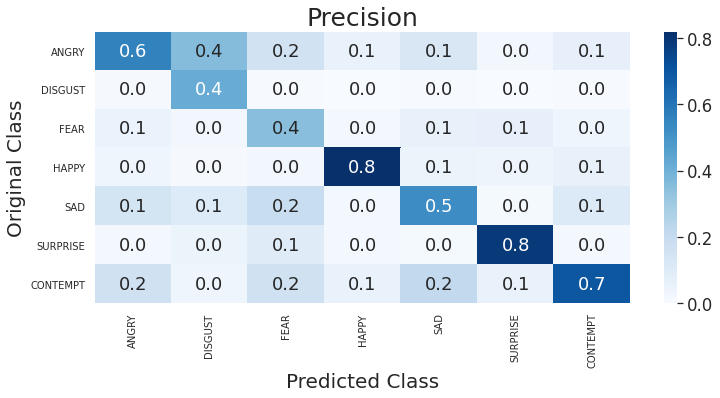

-------------------------------------------------------------------------------------
[0.55438864 0.5488541  0.48555383 0.91488243 0.53893694 0.83362943
 0.62125217] 0.6424996499382747


In [ ]:
#######################################
# MEASURE PERFORMANCE OF RESNET MODEL #
#######################################

resnet_y_pred, resnet_y_pred_bool, resnet_ap_list, resnet_ap = predict_and_measure(resnet_model,X_test_VGG,y_test)
print(resnet_ap_list, resnet_ap)

### Compare Models

In [ ]:
######################
# PRINT MAP BY MODEL #
######################

print(np.round(base_ap_list,2))
print(np.round(vgg_frozen_ap_list,2))
print(np.round(vgg_full_ap_list,2))
print(np.round(resnet_ap_list,2))

print(np.round(base_ap,2))
print(np.round(vgg_frozen_ap,2))
print(np.round(vgg_full_ap,2))
print(np.round(resnet_ap,2))





[0.5  0.65 0.44 0.87 0.47 0.78 0.57]
[0.34 0.3  0.29 0.59 0.36 0.61 0.39]
[0.63 0.66 0.57 0.93 0.6  0.86 0.65]
[0.55 0.55 0.49 0.91 0.54 0.83 0.62]
0.61
0.41
0.7
0.64


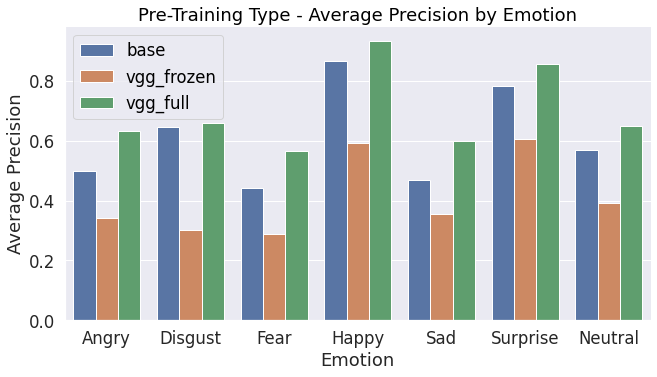

In [ ]:
###############################################
# VISUALIZE PRE-TRAINING PERFORMANCE BY CLASS #
###############################################

import seaborn as sns

# Create df for visualizing plot
model_df = pd.DataFrame(
    {'base': base_ap_list,
     'vgg_frozen': vgg_frozen_ap_list,
     'vgg_full': vgg_full_ap_list,
    })
model_df.index = label_names
model_list = ['base','vgg_frozen','vgg_full']
model_df = pd.melt(model_df.reset_index(), id_vars="index", var_name="model", value_vars=model_list)

# Plot AP by class
g=sns.catplot(x='index', y='value', hue='model', data=model_df, kind='bar')
g._legend.remove()
g.fig.set_size_inches(15,5)
plt.legend(loc='upper left')
g.set(xlabel="Emotion", ylabel = "Average Precision", title='Pre-Training Type - Average Precision by Emotion')

g.savefig(os.path.join(base_path, 'report_images/pretraining_by_emo.png'))

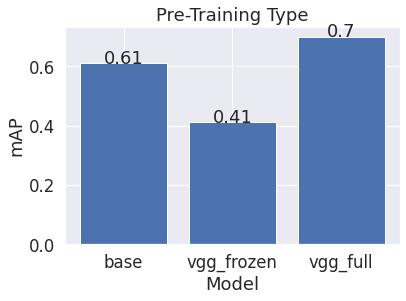

In [ ]:
######################################
# VISUALIZE PRE-TRAINING PERFORMANCE #
######################################

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

ax = plt.subplot()
pnsr_bar = ax.bar(model_list,[base_ap,vgg_frozen_ap,vgg_full_ap])
ax.set_title('Pre-Training Type')
ax.set_xlabel('Model')
ax.set_ylabel('mAP')

addlabels(model_list,np.round([base_ap,vgg_frozen_ap,vgg_full_ap],2))

plt.savefig(os.path.join(base_path, 'report_images/pretraining_map.png'),bbox_inches="tight")

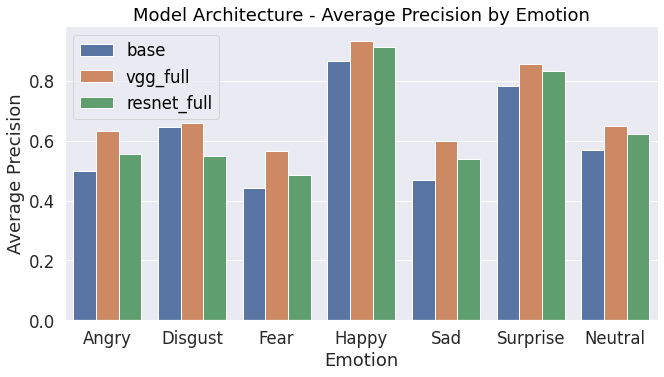

In [ ]:
###############################################
# VISUALIZE ARCHITECTURE PERFORMANCE BY CLASS #
###############################################

import seaborn as sns

# Create df for visualizing plot
model_df2 = pd.DataFrame(
    {'base': base_ap_list,
     'vgg_full': vgg_full_ap_list,
     'resnet_full': resnet_ap_list
    })
model_df2.index = label_names
model_list2 = ['base','vgg_full','resnet_full']
model_df2 = pd.melt(model_df2.reset_index(), id_vars="index", var_name="model", value_vars=model_list2)

# Plot AP by class
g=sns.catplot(x='index', y='value', hue='model', data=model_df2, kind='bar')
g._legend.remove()
g.fig.set_size_inches(15,5)
plt.legend(loc='upper left')
g.set(xlabel="Emotion", ylabel = "Average Precision", title='Model Architecture - Average Precision by Emotion')

g.savefig(os.path.join(base_path, 'report_images/architecture_by_emo.png'))

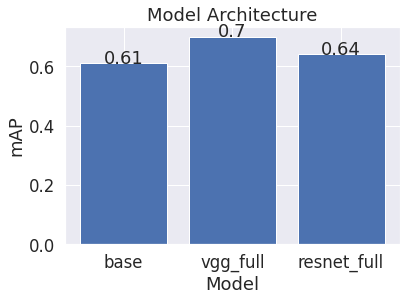

In [ ]:
######################################
# VISUALIZE ARCHITECTURE PERFORMANCE #
######################################

ax = plt.subplot()
pnsr_bar = ax.bar(model_list2,[base_ap,vgg_full_ap,resnet_ap])
ax.set_title('Model Architecture')
ax.set_xlabel('Model')
ax.set_ylabel('mAP')

addlabels(model_list,np.round([base_ap,vgg_full_ap,resnet_ap],2))

plt.savefig(os.path.join(base_path, 'report_images/architecture_map.png'),bbox_inches="tight")

## Face Restoration
There is a strong chance the customers faces will be distorted or difficult to see in the security camera footage given: the position of the cameras, the quality of the cameras, the distance from the camera, and poor lighting conditions. While there are a lot of approaches to fixing these issues, we will focus specifically on recovering noisy faces before feeding them through the model for detection.

As an experiemnt, three methods will be compared to measure their ability to denoise the images.

*   Median Filter
*   BM3D
*   Vanilla Autoencoder (convolution layers only)



#### Create Distorted Images

In [ ]:
########################
# NOISE DATA SAVE/LOAD #
########################

# # # Save processed noise images to Google Drive (uncomment and rerun if changes are made to processing)
# noise_X_train = add_salt_pepper_noise(X_train)/255
# noise_X_test = add_salt_pepper_noise(X_test)/255
# noise_X_val = add_salt_pepper_noise(X_val)/255
# np.save(os.path.join(base_path, 'data/noise_X_train.npy'), noise_X_train)
# np.save(os.path.join(base_path, 'data/noise_X_test.npy'), noise_X_test)
# np.save(os.path.join(base_path, 'data/noise_X_val.npy'), noise_X_val)

# Load data from Google Drive to prevent having to process data again
noise_X_train = np.load(os.path.join(base_path, 'data/noise_X_train.npy'))
noise_X_test = np.load(os.path.join(base_path, 'data/noise_X_test.npy'))
noise_X_val = np.load(os.path.join(base_path, 'data/noise_X_val.npy'))


# # Normalize X for later models
# actual = X.astype('float32')/255

# # Split noise data and actual data into test, train, val
# input_train, input_temp, actual_train, actual_temp = train_test_split(input_aug, actual, test_size=0.10, random_state=42)
# input_test, input_val, actual_test, actual_val = train_test_split(input_temp, actual_temp, test_size=0.5, random_state=42)


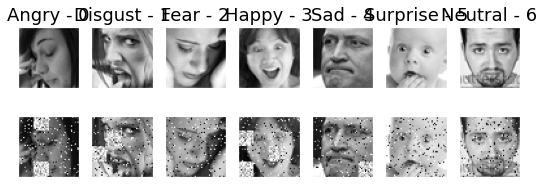

In [ ]:
######################################
# VISUALIZE NOISE IMAGES FOR REPORTS #
######################################

import matplotlib as mpl
mpl.rcParams['text.color'] = 'black'

fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(9, 3))

for i,emo in enumerate(label_names):
  emo_mask = y_train_original == i
  emo_img = X_train[emo_mask][0]
  axes[0,i].imshow(emo_img.reshape(48, 48), cmap='gray')
  axes[0,i].set_title('{} - {}'.format(emo,i))
  axes[0,i].get_xaxis().set_visible(False)
  axes[0,i].get_yaxis().set_visible(False)

for i,emo in enumerate(label_names):
  emo_mask = y_train_original == i
  emo_img = noise_X_train[emo_mask][0]
  axes[1,i].imshow(emo_img.reshape(48, 48), cmap='gray')
  # axes[1,i].set_title('{} - {}'.format(emo,i))
  axes[1,i].get_xaxis().set_visible(False)
  axes[1,i].get_yaxis().set_visible(False)


#### Build Denoise Autoencoder

In [ ]:
##########################
# LOAD AUTOENCODER MODEL #
##########################

# Load json and create model
json_file = open(os.path.join(base_path, 'AutoencoderModel.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder = model_from_json(loaded_model_json)

# Load weights into new model
autoencoder.load_weights(os.path.join(base_path, 'AutoencoderModel.h5'))

print("Loaded model from Google Drive")

# Compile autoencoder and print summary of architecture
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
print(autoencoder.summary())

Loaded model from Google Drive
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 256)       2560      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)       295040    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
up_sampling2d_2 (UpSampling2

In [ ]:
# #################################################
# # AUTOENCODER MODEL - UNCOMMENT TO CHANGE MODEL #
# #################################################

# # Set input image size
# input_img = Input(shape=(48, 48, 1))

# # Build encoder model architecture
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)

# # Build decoder model architecture
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# # Create and compile autoencoder
# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# print(autoencoder.summary())

# # Set model checkpoints
# checkpoint = ModelCheckpoint('AutoencoderModel.h5',
#                              monitor='val_loss',
#                              mode='min',
#                              save_best_only=True,
#                              verbose=1)

# # Set early stopping rules
# earlystop = EarlyStopping(monitor='val_loss',
#                           min_delta=0,
#                           patience=3,
#                           verbose=1,
#                           restore_best_weights=True
#                           )

# # Set adaptive learning rate rules
# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.2,
#                               patience=3,
#                               verbose=1,
#                               min_delta=0.0001)

# # Combine checkpoint, early stopping and adaptive learning rate into callback list
# callbacks = [earlystop,checkpoint,reduce_lr]

# # Fit autoencoder
# history_autoencoder = autoencoder.fit(noise_X_train, 
#                           X_train/255, 
#                           epochs= 50, 
#                           batch_size= 128, 
#                           shuffle=True, 
#                           callbacks = callbacks,
#                           validation_data=(noise_X_val, X_val/255)
#                           )

In [ ]:
###################################
# AUTOENCODER LOSS LEARNING CURVE #
###################################

plot_loss(history_autoencoder)

In [ ]:
# ########################################################################
# # SAVE AUTOENCODER MODEL - UNCOMMENT IF CHANGES WERE MADE TO THE MODEL #
# ########################################################################

# # Serialize model to JSON
# model_json = autoencoder.to_json()
# with open(os.path.join(base_path, 'AutoencoderModel.json'), "w") as json_file:
#     json_file.write(model_json)

# # Serialize weights to HDF5
# autoencoder.save_weights(os.path.join(base_path, 'AutoencoderModel.h5'))

# print("Saved model to Google Drive")

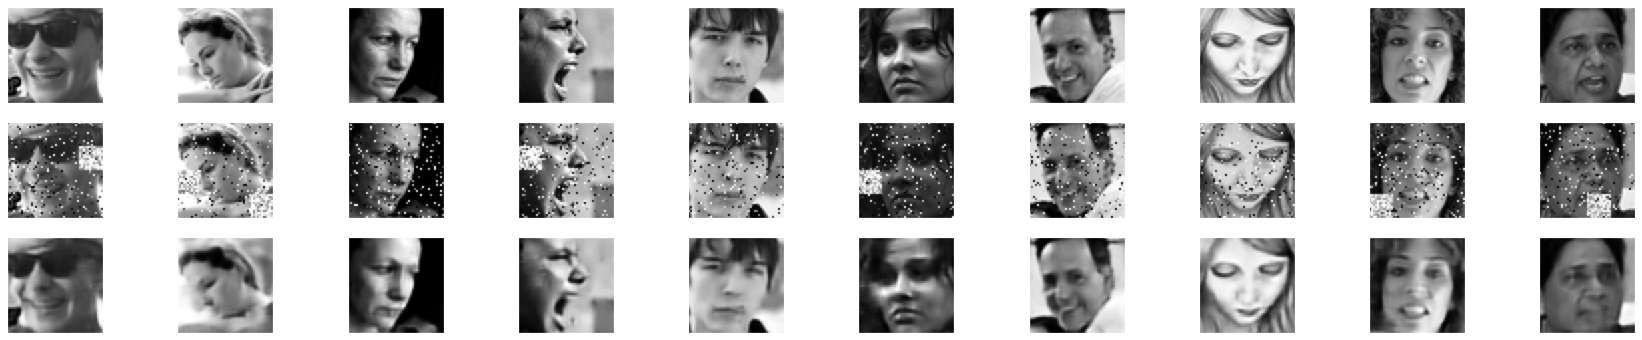

In [ ]:
##################################
# DECODE TEST DATA AND VISUALIZE #
##################################

# Decode faces with noise
decoded_imgs = autoencoder.predict(noise_X_test)

# Plot the actual, noise, and reconstructed faces
plot_img(10, X_test, noise_X_test, decoded_imgs)

#### Denoise Comparisons

In [ ]:
############################################
# RUN DENOISING FILTERS AND CALCULATE PSNR #
############################################

# Initialize lists of denoised images
bm3d_images = []
median_images = []

# Initialise list of loss scores
denoise_comparison = []

# Loop through all test images
for i,img in enumerate(noise_X_test):

  # Apply BM3D denoising and append to BM3D list
  bm3d_image = bm3d.bm3d(img, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
  bm3d_images.append(bm3d_image)
  
  # Apply Median convolution and append to media list
  median_image = cv2.medianBlur(img, 3)
  median_images.append(median_image)

  # Convert actual test images to comparable list
  actual = X_test[i]

  # Compute PSNR score for each noise/denoise image
  noise_psnr = compare_psnr(actual, img)
  median_psnr = compare_psnr(actual, median_image.reshape(48,48,1))
  bm3d_psnr = compare_psnr(actual, bm3d_image.reshape(48,48,1))
  decoded_psnr = compare_psnr(actual, decoded_imgs[i])

  # Append list (of each image) of tuple scores (PSNR, MSE) to denoise_comparison list
  denoise_comparison.append([noise_psnr, median_psnr, bm3d_psnr, decoded_psnr])

PNSR
64.16087630404131 70.77122405959452 68.56610238861201 74.81993728776301
MSE
0.027 0.01 0.0119 0.0027


Text(0.5, 1.0, 'MSE')

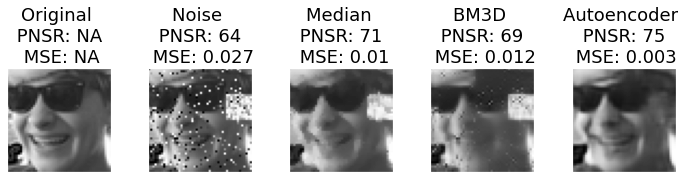

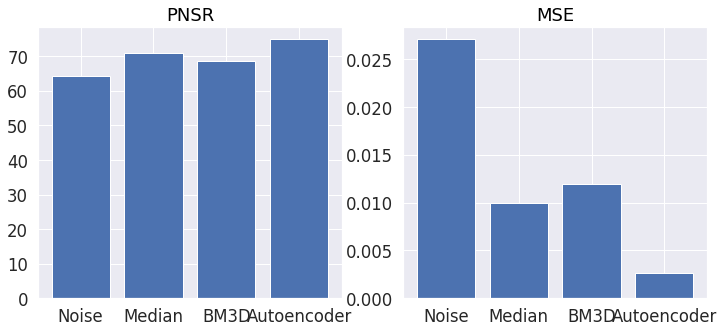

In [ ]:
#########################################
# COMPARE AVERAGE DENOISING PERFORMANCE #
#########################################

# Compute the average PNSR for each denoising approach
avg_noise_pnsr = np.mean([denoise_comparison[i][0][0] for i, img in enumerate(noise_X_test)])
avg_median_pnsr = np.mean([denoise_comparison[i][1][0] for i, img in enumerate(noise_X_test)])
avg_bm3d_pnsr = np.mean([denoise_comparison[i][2][0] for i, img in enumerate(noise_X_test)])
avg_decoded_pnsr = np.mean([denoise_comparison[i][3][0] for i, img in enumerate(noise_X_test)])
print("PNSR")
print(avg_noise_pnsr, avg_median_pnsr, avg_bm3d_pnsr, avg_decoded_pnsr)

# Compute the average MSE for each denoising approach
avg_noise_mse = np.mean([denoise_comparison[i][0][1] for i, img in enumerate(noise_X_test)])
avg_median_mse = np.mean([denoise_comparison[i][1][1] for i, img in enumerate(noise_X_test)])
avg_bm3d_mse = np.mean([denoise_comparison[i][2][1] for i, img in enumerate(noise_X_test)])
avg_decoded_mse = np.mean([denoise_comparison[i][3][1] for i, img in enumerate(noise_X_test)])
print("MSE")
print(round(avg_noise_mse,4), round(avg_median_mse,4), round(avg_bm3d_mse,4), round(avg_decoded_mse,4))

# Visualize denoising approaches
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
axes[0].imshow(X_test[0].reshape(48, 48))
axes[0].set_title('Original \n PNSR: {} \n MSE: {}'.format( 'NA', 'NA' ))
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

axes[1].imshow(noise_X_test[0].reshape(48, 48))
axes[1].set_title('Noise \n PNSR: {} \n MSE: {}'.format( round(avg_noise_pnsr), round(avg_noise_mse.astype('float64'),3) ))
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

axes[2].imshow(median_images[0].reshape(48, 48))
axes[2].set_title('Median \n PNSR: {} \n MSE: {}'.format( round(avg_median_pnsr), round(avg_median_mse.astype('float64'),3) ))
axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)

axes[3].imshow(bm3d_images[0].reshape(48, 48))
axes[3].set_title('BM3D \n PNSR: {} \n MSE: {}'.format( round(avg_bm3d_pnsr), round(avg_bm3d_mse.astype('float64'),3) ))
axes[3].get_xaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)

axes[4].imshow(decoded_imgs[0].reshape(48, 48))
axes[4].set_title('Autoencoder \n PNSR: {} \n MSE: {}'.format( round(avg_decoded_pnsr), round(avg_decoded_mse.astype('float64'),3) ))
axes[4].get_xaxis().set_visible(False)
axes[4].get_yaxis().set_visible(False)

fig.tight_layout()

# Plot bar chart of comparison scores
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

pnsr_bar = axes[0].bar(['Noise', 'Median', 'BM3D', 'Autoencoder'],[avg_noise_pnsr, avg_median_pnsr, avg_bm3d_pnsr, avg_decoded_pnsr])
axes[0].set_title('PNSR')

mse_bar = axes[1].bar(['Noise', 'Median', 'BM3D', 'Autoencoder'],[avg_noise_mse, avg_median_mse, avg_bm3d_mse, avg_decoded_mse])
axes[1].set_title('MSE')

#### Denoised Images Classification Model Performance

In this section the best emotion detection algorithm is tested to see if it makes sense to denoise images before predicting. The model is tested on:


*   Original images
*   Original images (no noise) passed through the denoising Autoencoder
*   Noise images
*   Noise images passed through the denoising Autoencoder
*   Noise images passed though a model trained with noisy images

In [ ]:
##################################################
# PROCESS DATA TO TRAIN BEST MODEL ON NOISE DATA #
##################################################

# Create a copy of the original X_train and X_val and append the noise_X_train/ noise_X_val to them
noise_X_train_copy = X_train_VGG.copy()
noise_X_train_copy = np.concatenate((toThreeChannels(noise_X_train),noise_X_train_copy) )
noise_X_val_copy = X_val_VGG.copy()
noise_X_val_copy = np.concatenate((toThreeChannels(noise_X_val),noise_X_val_copy) )

# Append two y_train arrays together to align with the new X_train
noise_y_train_copy = np.concatenate((y_train.copy(),y_train.copy()))
noise_y_val_copy = np.concatenate((y_val.copy(),y_val.copy()))

In [ ]:
####################
# LOAD NOISE MODEL #
####################

# Load json and create model
json_file = open(os.path.join(base_path, 'BaseModelNoise.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
model_noise = model_from_json(loaded_model_json)

# Load weights into new model
model_noise.load_weights(os.path.join(base_path, 'BaseModelNoise.h5'))

print("Loaded model from Google Drive")

# Compile noise model and print summary of architecture
model_noise.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

print(model_noise.summary())

Loaded model from Google Drive
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_17 (Dropout)  

In [ ]:
##################################
# INITIALIZE NOISE MODEL AND FIT #
##################################

# Initialize VGG 16 model
model_noise=VGG16(
    include_top=False,
    weights="imagenet", input_shape=(48,48,3))

# Set all layers to be trainable
for i, layer in enumerate(model_noise.layers):
    print(i, layer.name, layer.trainable)

# Add fully connected layers
X = model_noise.layers[-1].output
X1 = Flatten()(X)
X2 = Dense(512, activation='relu')(X1)
X3 = Dropout(0.6)(X2)
X4 = Dense(256, activation='relu')(X3)
X5 = BatchNormalization()(X4)
X6 = Dense(128, activation='relu')(X5)
X7 = Dense(64, activation='relu')(X6)
predictions = Dense(num_classes, activation="softmax")(X7)

model_noise = Model(inputs = model_noise.input, outputs = predictions)

# Compile and sumarize model
model_noise.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.00001), metrics=["accuracy"])
model_noise.summary()


# FIT NOISE VGG16 ALL TRAINABLE MODEL

nb_train_samples = noise_y_train_copy.shape[0]
nb_validation_samples = noise_X_val_copy.shape[0]

earlystop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.3,
                              patience=2,
                              verbose=1,
                              mode='max',
                              min_lr=5e-8)

callbacks = [earlystop,reduce_lr]

model_noise_history=model_noise.fit(
                datagen.flow(noise_X_train_copy, noise_y_train_copy, batch_size=batch_size),
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=50,
                callbacks=callbacks,
                validation_data=datagen.flow(noise_X_val_copy, noise_y_val_copy),
                validation_steps=nb_validation_samples//batch_size)

0 input_3 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
__________

116/116 - 2s - loss: 0.9400 - accuracy: 0.6686


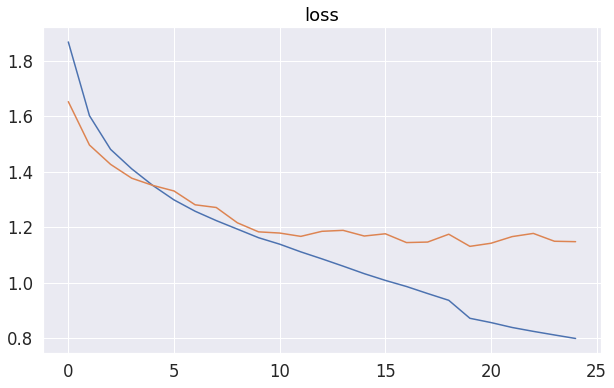

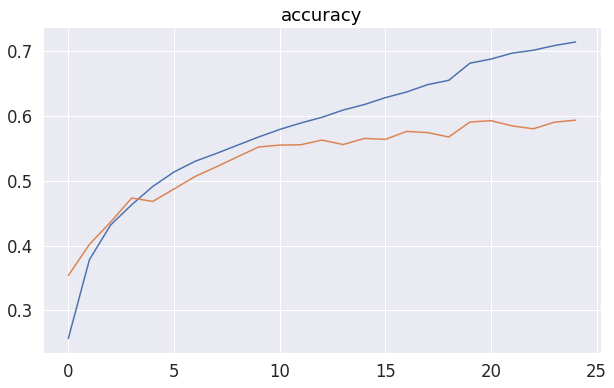

In [ ]:
# ###############################################
# # DON'T RUN THIS IF NOT RE-TRAINING THE MODEL #
# ###############################################
plot_loss(model_noise_history)

plot_accuracy(model_noise_history)  

scores = model_noise.evaluate(X_test_VGG, y_test, verbose=2)

In [ ]:
##################################################################
# SAVE NOISE MODEL - UNCOMMENT IF CHANGES WERE MADE TO THE MODEL #
##################################################################

# Serialize model to JSON
model_json = model_noise.to_json()
with open(os.path.join(base_path, 'BaseModelNoise.json'), "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model_noise.save_weights(os.path.join(base_path, 'BaseModelNoise.h5'))

print("Saved model to Google Drive")

Saved model to Google Drive


116/116 [==============================] - 1s 7ms/step


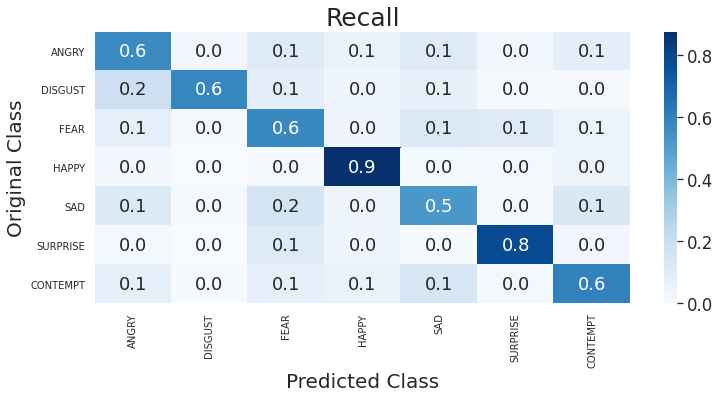

-------------------------------------------------------------------------------------


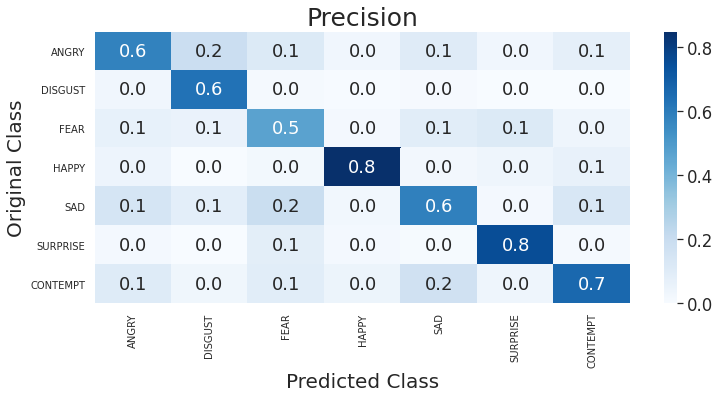

-------------------------------------------------------------------------------------
[0.6452606  0.66494973 0.56572505 0.93533426 0.58853075 0.85727358
 0.65617027] 0.701892034662789


In [ ]:
###############################################
# MEASURE PERFORMANCE OF VGG FULL NOISE MODEL #
###############################################

noise_model_y_pred, noise_model_y_pred_bool, noise_model_ap_list, noise_model_ap = predict_and_measure(model_noise,X_test_VGG,y_test)
print(noise_model_ap_list, noise_model_ap)

In [ ]:
###############################
# NOISE PREDICTION EXPERIMENT #
###############################

# Base Model
y_pred = vgg_full_model.predict(X_test_VGG, batch_size=32, verbose=1)
ap_list = average_precision_score(y_test, y_pred, average = None)
ap = np.mean(ap_list)
print(ap_list,ap)

# Denoising non-noisy images
decoded_imgs1 = autoencoder.predict(X_test)
y_pred_ae = vgg_full_model.predict(toThreeChannels(decoded_imgs1), batch_size=32, verbose=1)
ap_list_ae = average_precision_score(y_test, y_pred_ae, average = None)
ap_ae = np.mean(ap_list_ae)
print(ap_list_ae,ap_ae)

# Noisy images
y_pred_ae2 = vgg_full_model.predict(toThreeChannels(noise_X_test), batch_size=32, verbose=1)
ap_list_ae2 = average_precision_score(y_test, y_pred_ae2, average = None)
ap_ae2 = np.mean(ap_list_ae2)
print(ap_list_ae2,ap_ae2)

# Denoising noisy images
decoded_imgs3 = autoencoder.predict(noise_X_test)
y_pred_ae3 = vgg_full_model.predict(toThreeChannels(decoded_imgs3), batch_size=32, verbose=1)
ap_list_ae3 = average_precision_score(y_test, y_pred_ae3, average = None)
ap_ae3 = np.mean(ap_list_ae3)
print(ap_list_ae3,ap_ae3)

# Training with noisy images and not applying fix
y_pred4 = model_noise.predict(toThreeChannels(noise_X_test), batch_size=32, verbose=1)
ap_list4 = average_precision_score(y_test, y_pred4, average = None)
ap4 = np.mean(ap_list4)
print(ap_list4,ap4)

116/116 [==============================] - 1s 7ms/step
[0.63104753 0.66054921 0.5656798  0.93455203 0.59821391 0.8554027
 0.64985627] 0.6993287787717108
116/116 [==============================] - 1s 7ms/step
[0.5876303  0.60928332 0.54067241 0.91309053 0.57042284 0.83062478
 0.6029896 ] 0.66495911064527
116/116 [==============================] - 1s 7ms/step
[0.24143776 0.03189411 0.23866888 0.50804043 0.25469241 0.49218962
 0.24488747] 0.28740152632362526
116/116 [==============================] - 1s 7ms/step
[0.55918136 0.53783571 0.47251005 0.88241866 0.53579542 0.79589384
 0.58183507] 0.6236385864982276
116/116 [==============================] - 1s 7ms/step
[0.51813965 0.41256867 0.42989585 0.85896044 0.46524984 0.77623701
 0.53644519] 0.5710709496858015


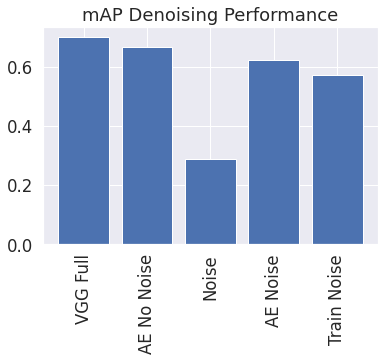

In [ ]:
##########################################
# PLOT MAP RESULTS FROM NOISE EXPERIMENT #
##########################################

ax = plt.subplot()
pnsr_bar = ax.bar(['Base', 'AE No Noise', 'Noise', 'AE Noise', 'Train Noise'],[ap, ap_ae, ap_ae2, ap_ae3, ap4])
ax.set_title('mAP Denoising Performance')
plt.xticks(rotation=90)
plt.savefig(os.path.join(base_path, 'report_images/noise_performance.png'),bbox_inches="tight")

## Self-Training

Given the employees do not have time to sit through thousands of hours of footage and label the customers emotions, we plan to use semi-supervised methods to label security camera footage. For this approach, the best model from above is used to output a softmax probability. From there a probability threshold is used to decide with a level of confidence what images to keep as newly labeled for future training.

To determine the best threshold to use, a test is conducted at various tiers comparing the mAP and number of images.

#### Build Self-Training Model

In [ ]:
################################################
# CALCULATE SELF-TRAINING RESULTS BY THRESHOLD #
################################################

# Create dataframe of predicted and actual classifications
df = pd.DataFrame(vgg_full_y_pred, columns = label_names)
df['pred_class'] = vgg_full_y_pred_bool
df['pred_prob'] = np.max(vgg_full_y_pred, axis = 1)
df['actual_class'] = np.argmax(y_test, axis=1)

# Generate column names for one hot encoded actual test classifications
actual_label_names = ['actual_{}'.format(name) for name in label_names]

# Create dataframe of one hoe encoded actual test classifications
df2 = pd.DataFrame(y_test, columns = actual_label_names)

# Join predicted df and actual df2
df = df.merge(df2, left_index=True, right_index=True)

# Set confidence thresholds to loop through
confidence_thresholds = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]

# Initialize lists for mAP and number of images by threshold
mAP_by_threshold = []
number_of_images_list = []

# Loop through each threshold to calculate mAP and number of images
for threshold in confidence_thresholds:

  # Create mask filter for threshold level
  mask = df['pred_prob']>=threshold

  # Apply mas filter to df and calculate mAP
  mAP = average_precision_score(df.loc[mask,actual_label_names].to_numpy(),df.loc[mask,label_names].to_numpy())

  # Append map to mAP list
  mAP_by_threshold.append(mAP)

  # Calculated the number of images and append to list
  number_of_images_list.append(np.sum(mask))

[0.6993287787717108, 0.6993287787717108, 0.6994227861535328, 0.702915457319481, 0.7191202815575436, 0.7456175933210903, 0.7738840945179184, 0.7999188488434896, 0.819245976983501, 0.8451838646191099]
[3687, 3687, 3686, 3647, 3389, 2998, 2565, 2162, 1738, 1261]


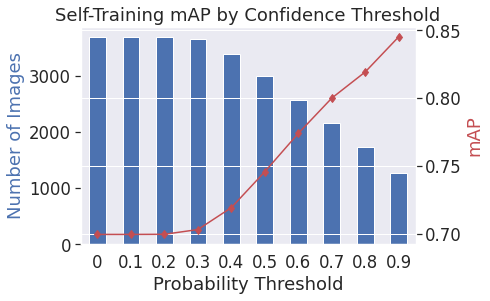

In [ ]:
###############################################
# PLOT THE SELF-TRAINING RESULTS BY THRESHOLD #
###############################################

print(mAP_by_threshold)
print(number_of_images_list)

# Create dataframe with results combined
df_plot = pd.DataFrame({'mAP': mAP_by_threshold,
                   'number_of_images': number_of_images_list})

# Plot bar with number of images first 
ax1 = df_plot['number_of_images'].plot(kind='bar', color='b')
ax1.set_ylabel("Number of Images", color = 'b')
ax1.set_xlabel("Probability Threshold")
ax1.set_xticklabels([str('0.9') if a == 0.898 else str(a) for a in confidence_thresholds])
ax1.set_title('Self-Training mAP by Confidence Threshold')

# Add mAP as a line on the second y axis
ax2 = df_plot['mAP'].plot(kind='line', marker='d',color='r', secondary_y=True)
ax2.set_ylabel("mAP", color='r')

plt.savefig(os.path.join(base_path, 'report_images/self_training.png'),bbox_inches="tight")

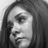

Predicted: Neutral
Confidence: 0.5
Actual: Angry



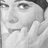

Predicted: Fear
Confidence: 0.57
Actual: Happy



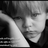

Predicted: Neutral
Confidence: 0.54
Actual: Sad



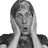

Predicted: Fear
Confidence: 0.57
Actual: Surprise



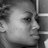

Predicted: Neutral
Confidence: 0.53
Actual: Angry



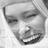

Predicted: Sad
Confidence: 0.55
Actual: Happy



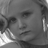

Predicted: Sad
Confidence: 0.51
Actual: Neutral



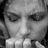

Predicted: Fear
Confidence: 0.59
Actual: Sad



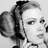

Predicted: Fear
Confidence: 0.52
Actual: Neutral



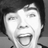

Predicted: Fear
Confidence: 0.53
Actual: Happy



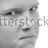

Predicted: Surprise
Confidence: 0.6
Actual: Angry



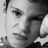

Predicted: Angry
Confidence: 0.53
Actual: Sad



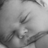

Predicted: Happy
Confidence: 0.56
Actual: Neutral



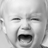

Predicted: Fear
Confidence: 0.57
Actual: Sad



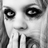

Predicted: Fear
Confidence: 0.51
Actual: Sad



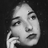

Predicted: Neutral
Confidence: 0.56
Actual: Sad



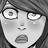

Predicted: Neutral
Confidence: 0.59
Actual: Surprise



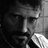

Predicted: Sad
Confidence: 0.53
Actual: Neutral



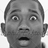

Predicted: Fear
Confidence: 0.53
Actual: Surprise



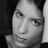

Predicted: Angry
Confidence: 0.59
Actual: Sad



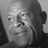

Predicted: Neutral
Confidence: 0.59
Actual: Happy



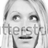

Predicted: Fear
Confidence: 0.56
Actual: Surprise



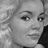

Predicted: Happy
Confidence: 0.56
Actual: Neutral



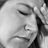

Predicted: Sad
Confidence: 0.6
Actual: Angry



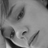

Predicted: Neutral
Confidence: 0.54
Actual: Fear



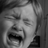

Predicted: Angry
Confidence: 0.52
Actual: Sad



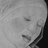

Predicted: Fear
Confidence: 0.58
Actual: Sad



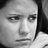

Predicted: Sad
Confidence: 0.57
Actual: Fear



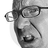

Predicted: Angry
Confidence: 0.58
Actual: Disgust



In [ ]:
#################################################################
# DISPLAY IMAGES ALONG SIDE PREDICTED AND ACTUAL CLASSIFICATION #
#################################################################

# Set mask of images to ideal probability threshold
mask1 = df['pred_prob']>=.5
mask2 = df['pred_prob']<.6

# Loop through all images only displaying the ones that at true int he mask
for i, row in df.iloc[0:500,].iterrows():
  if mask1[i] and mask2[i] and int(row['pred_class'])!=int(row['actual_class']):
    cv2_imshow(X_test[i]*255)
    print('Predicted: {}'.format(label_names[int(row['pred_class'])]))
    print('Confidence: {}'.format( round(row['pred_prob'], 2 ) ) )
    print('Actual: {}'.format(label_names[int(row['actual_class'])]))
    print("")

#### Label Unlabeled Data

This section has the pipeline created for future semi-supervised learning.

In [ ]:
###################################################
# FUNCTION/PIPLELINE FOR SEMI-SUPERVISED LEARNING #
###################################################

def semisupervised_labeling(model, X, y = None, threshold = 0.9):
  """
  Parameters:
  model: Keras model that classifies images
  X: numpy array of images as input to Keras model
  y: numpy array of correct labels (not required will output mAP if included or skip if not included)
  threshold: the probability threshold used to filter out images (defaults to 0.7)

  Return:
  new_X: numpy array of new images
  new_y: numpy array of new image predicted labels
  mAP: the calculated mean average percision if y was provided
  """
  # Predict labels for X input
  y_pred = model.predict(X)

  # Calculate the classification for the predicted y
  y_pred_bool = np.argmax(y_pred, axis=1)

  # Create dataframe of predicted classifications
  df = pd.DataFrame(y_pred, columns = label_names)
  df['pred_class'] = y_pred_bool
  df['pred_prob'] = np.max(y_pred, axis = 1)

  # Apply y columns to df if y is provided
  if y is not None:
    # Add actual classifications 
    df['actual_class'] = np.argmax(y, axis=1)

    # Generate column names for one hot encoded actual test classifications
    actual_label_names = ['actual_{}'.format(name) for name in label_names]

    # Create dataframe of one hoe encoded actual test classifications
    df2 = pd.DataFrame(y, columns = actual_label_names)

    # Join predicted df and actual df2
    df = df.merge(df2, left_index=True, right_index=True)

  # Create mask filter for threshold level
  mask = df['pred_prob']>=threshold

  # Initialize mAP and check if y is provided to calculate
  mAP = None
  if y is not None:
    # Apply mas filter to df and calculate mAP
    mAP = average_precision_score(df.loc[mask,actual_label_names].to_numpy(),df.loc[mask,label_names].to_numpy(), average = None)
    mAP = np.mean(mAP[~np.isnan(mAP)])

  # Initialize new image lists
  new_X = []
  new_y = []

  # Loop through new images that are greater than threshold
  for i, row in df.iterrows():

    # Skip rows that are below the threshold
    if mask[i]:

      # Append image and label to list
      new_X.append(X[i])
      new_y.append(row['pred_class'])

  return np.array(new_X), np.array(new_y), mAP

In [ ]:
#############################################
# RUN SEMI-SUPERVISED FUNCTION ON TEST DATA #
#############################################

new_X, new_y, new_mAP = semisupervised_labeling(vgg_full_model, X_test_VGG, y_test)
print(new_X.shape)
print(new_y.shape)
print(new_mAP)

(1261, 48, 48, 3)
(1261,)
0.8451838646191099


## Unlabelled Data Experiments 

Unfortunately there is not any security footage from past seasons, so to simulate this part of the pipeline, we plan to scrape unlabeled images from Google (as the proxy for security footage) and label the images using semi-supervised learning. This section will contain experiments to see if the added self-trained data helps improve model performance and the best approach for self supervised learning.


#### Scrape Bing Images
To simulate the unlabeled data that will come from the security cameras in the attraction, images of faces and guests going through attractions were extracted from Bing Images.

In [ ]:
# #######################################################
# # SCRAPE FACE IMAGES FROM BING - CAN ONLY RUN LOCALLY #
# #######################################################

# # Set path to save the data
# path = 'C:\\Users\\derek\\Google Drive\\UNIPD\\Semester2\\Vision and Cognitive Services\\VIS_Project_EmoDetection\\data\\bing'

# # Create list of queries to reach for in Bing images
# queries = ['angry human face','disgust human face','fear human face',
#            'happy human face','sad human face','surprise human face',
#            'neutral human face', 'scared haunted house reactions' ]

# # Loop through each query
# for query in queries:
#     # Get a cleaned up name for the query and create new path with it
#     name = query.split(" ")[0]
#     sub_path = os.path.join(path, name)
#     print(name)

#     # Fetch query from Bing images and save the list of urls for each image
#     urls = bing.fetch_image_urls(query, limit=100)
#     print("{} images.".format(len(urls)))

#     # Make new directory if sub_path doesnt exist
#     if not os.path.exists(sub_path):
#         os.makedirs(sub_path)
#     os.chdir(sub_path)
    
#     # Loop through each image URL
#     counter = 1
#     for url in urls:

#         # Skip URLs causing errors
#         if url not in ['http://www.the-emotions.com/images/disgust-382x220.jpg']:
#             print("{}: {}".format(counter, url))

#             # Request image from URL and write it to the current directory
#             img_data = requests.get(url).content
#             with open('{}_{}.jpg'.format(name, counter), 'wb') as handler:
#                 handler.write(img_data)
#             counter += 1
    

In [ ]:
# ##########################################################
# # BING NOISE PROCESSING - UNCOMMENT TO CHANGE PROCESSING #
# ##########################################################

# # Apply noise to Bing images
# bing_input_aug = add_salt_pepper_noise(bing_input)/255

# # Apply float32 to bing_input for later processing
# bing_actual = bing_input.astype('float32')

In [ ]:
#######################
# BING DATA SAVE/LOAD #
#######################

# # Save processed Bing images to Google Drive (uncomment and rerun if changes are made to processing)
# np.save(os.path.join(base_path, 'data/bing_face_noise.npy'), bing_input_aug)
# np.save(os.path.join(base_path, 'data/bing_face.npy'), bing_actual)

#Load data from Google Drive to prevent having to process data again
bing_input_aug = np.load(os.path.join(base_path, 'data/bing_face_noise.npy'))
bing_actual = np.load(os.path.join(base_path, 'data/bing_face.npy'))

#### Extract Only Faces
Once images are scraped, we will use an out of the box DNN face detection algorithm to identify all faces and extract them as individual images.

In [ ]:
########################
# EXTRACT FACES - HARR #
########################

# Set paths for later operations
bing_path_original = os.path.join(base_path, 'data/bing_scrape/original_images')
bing_path = os.path.join(base_path, 'data/bing_scrape')
base_dir = os.path.dirname(os.path.join(base_path, 'data/bing_scrape')) 

# Grab all folders in bing_path_original
bing_folders = sorted(os.listdir(bing_path_original))

# Loop through all folder (currenly overriding to only look at "scared" folder)
n = 0
# for idx, bing_folder in enumerate([bing_folders]):
for idx, bing_folder in enumerate(['scared']):

  # Get all images in the folder
  images_path = os.path.join(bing_path_original, bing_folder)
  files = sorted(os.listdir(images_path))

  print(f"Cropping bing images ({bing_folder})...")

  # Loop through all images to detect faces and save them
  for image in files:

    # Implement try catch in case there are incompatable formats or corrupted files
    try:
      # Read image
      img_path = os.path.join(images_path, image)
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

      # Detect faces using harrcascades
      faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
      faces = faceCascade.detectMultiScale(
          img,
          scaleFactor=1.3,
          minNeighbors=3,
          minSize=(30, 30)
      )

      # Loop thorugh all face sin image to place rectangle around all faces detected in the image
      for (x, y, w, h) in faces:
        # Place rectangle around face
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # #If needed extract only the face form the image and save it
        # roi_color = img[y:y + h, x:x + w]
        # face_path = '{}{}{}{}_{}'.format(bing_path,"/cropped_faces/",w,h,image)
        # cv2.imwrite(face_path, roi_color)
      n += 1

      # Save image with rectangles around face
      img_path = base_dir + '/bing_scrape/updated_images_harr/' + image
      status = cv2.imwrite(img_path, img)
  
      print("[INFO] Image written to filesystem: ", image, status, "Found {0} Faces.".format(len(faces)))
    except:
      pass
print(f"Finished cropping images!")

In [ ]:
#############################
# EXTRACT FACES - DNN CAFFE #
#############################

# Set paths for later operations
bing_path_original = os.path.join(base_path, 'data/bing_scrape/original_images')
base_dir = os.path.dirname(os.path.join(base_path, 'data/bing_scrape')) 

# Grab all folders in bing_path_original
bing_folders = sorted(os.listdir(bing_path_original))

# Read the RNN model
prototxt_path = '/content/drive/MyDrive/UNIPD/Semester2/Vision and Cognitive Services/VIS_Project_EmoDetection/data/bing_scrape/model_data/deploy.prototxt'
caffemodel_path = '/content/drive/MyDrive/UNIPD/Semester2/Vision and Cognitive Services/VIS_Project_EmoDetection/data/bing_scrape/model_data/weights.caffemodel'
model_dnn = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

# Create directory 'updated_images' if it does not exist
os.chdir(os.path.join(base_path, 'data/bing_scrape'))
if not os.path.exists('updated_images'):
	print("New directory created")
	os.makedirs('updated_images')
 
# Create directory 'faces' if it does not exist
if not os.path.exists('faces'):
	print("New directory created")
	os.makedirs('faces')

# Loop through all folder (currenly overriding to only look at "scared" folder)
total = 0
# for idx, bing_folder in enumerate(bing_folders):
for idx, bing_folder in enumerate(['scared']):
  images_path = os.path.join(bing_path_original, bing_folder) 
  print(images_path)

  # Loop through all images and strip out faces
  for file in sorted(os.listdir(images_path)):
    count = 0
    file_name, file_extension = os.path.splitext(file)

    # Only process images with.png format and if image is None skip it
    if (file_extension in ['.png','.jpg']):
      image = cv2.imread(images_path + '/' + file)
      if image is None:
        continue
      
      # Get height and width of image and resize
      (h, w) = image.shape[:2]
      blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

      # Run model on images
      model_dnn.setInput(blob)
      detections = model_dnn.forward()

      # Identify each face
      for i in range(0, detections.shape[2]):
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        confidence = detections[0, 0, i, 2]

        # If confidence > 0.9, save it as a separate file
        if (confidence > 0.9):          
          frame = image[startY:endY, startX:endX]
          if (frame.shape[0]!=0) and (frame.shape[1]!=0):
            count += 1
            total += 1
            save_path = base_dir + '/bing_scrape/scared_faces/' + file_name + '_' + str(i) + file_extension
            cv2.imwrite(save_path, frame)

    print("Extracted " + str(count) + " faces from " + file + " - Total: " + str(total))

In [ ]:
#########################################
# PROCESS BING IMAGES FOR MODEL TESTING #
#########################################

# Initialize path and list to grab Bing face images
faces_path = os.path.join(base_path, 'data/bing_scrape/scared_faces/')
bing_input = []
bing_y = []

# Read manual classification file
manual_class_df = pd.read_csv(os.path.join(base_path, 'data/bing_scrape/scared_classifications.csv'))

# Loop through all Bing faces
for file in sorted(os.listdir(faces_path)):

  # Read image
  image = cv2.imread(faces_path + '/' + file, cv2.IMREAD_GRAYSCALE)

  # Get height and width of image
  (h, w) = image.shape[:2]

  # Skip if image is too small
  if min(h,w) > 48:
    # Get manual classification and append to list
    manual_y = manual_class_df.loc[manual_class_df['img_name']==file,'class'].values[0]
    bing_y.append(manual_y)

    # Resize image and append to bing_input list
    resized_img = resize(image)
    bing_input.append(resized_img.reshape(48,48,1))

# Convert list to numpy array
bing_input = np.array(bing_input)
bing_y = np.array(bing_y)

# One hot encode bing_y
bing_y_one = np.zeros((bing_y.size, bing_y.max()+1))
bing_y_one[np.arange(bing_y.size),bing_y] = 1
bing_y_one = np.array(bing_y_one)

# bing_y_one

In [ ]:
#######################
# BING DATA SAVE/LOAD #
#######################

# # Save processed Bing images to Google Drive (uncomment and rerun if changes are made to processing)
# np.save(os.path.join(base_path, 'data/bing_input_scared.npy'), bing_input)
# np.save(os.path.join(base_path, 'data/bing_y_scared.npy'), bing_y_one)

#Load data from Google Drive to prevent having to process data again
bing_input_scared = np.load(os.path.join(base_path, 'data/bing_input_scared.npy'))
bing_y_scared = np.load(os.path.join(base_path, 'data/bing_y_scared.npy'))

In [ ]:
###############################################
# RUN SEMI-SUPERVISED LEARNING ON BING IMAGES #
###############################################

new_bing_X, new_bing_y, new_bing_mAP = semisupervised_labeling(vgg_full_model, toThreeChannels(bing_input_scared/255),pd.DataFrame(bing_y_scared).to_numpy())

print(new_bing_X.shape)
print(new_bing_y.shape)
print(new_bing_mAP)

(21, 48, 48, 3)
(21,)
0.9660794067044065


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
